In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

<ipython-input-1-ac09909db896>:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data_path = '../LBLS160/data/'

In [4]:
br_pd = pd.read_csv(data_path + 'br.csv')
score_pd = pd.read_csv(data_path+'score.csv')
sill_pd = pd.read_csv(data_path+'sill.csv')
viscode_pd = pd.read_csv(data_path+'viscode.csv')
srl_m_pd = pd.read_csv(data_path+'srl_motivation.csv')


In [6]:
score_pd = score_pd.set_index('userid')
sill_pd = sill_pd.set_index('userid')
viscode_pd = viscode_pd.set_index('userid')
br_pd = br_pd.set_index('userid')
srl_m_pd = srl_m_pd.set_index('userid')

KeyError: "None of ['userid'] are in the columns"

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

def plt_pca (X_train, title, threshold):
    sc = StandardScaler()

    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    # X_test_std = sc.transform(X_test)
    #
    # Instantiate PCA
    #
    pca = PCA()
    #
    # Determine transformed features
    #
    X_train_pca = pca.fit_transform(X_train_std)
    #
    # Determine explained variance using explained_variance_ration_ attribute
    #
    exp_var_pca = pca.explained_variance_ratio_
    #
    # Cumulative sum of eigenvalues; This will be used to create step plot
    # for visualizing the variance explained by each principal component.
    #
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)
    comp = pca.components_
    
#     threshold=0.9
    running_sum = 0
    for index, entry in enumerate(exp_var_pca.flat):
        running_sum += entry
        if running_sum > threshold:
            break
    if running_sum < threshold:
        index = -1 #if the sum never reaches the threshold
    
    #
    # Create the visualization plot
    #
    plt.figure(figsize=(5, 2))
#     plt.title(title + ', threshold='+str(threshold)+', comp='+str(index))
    plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.2, align='center', label='Individual explained variance')
    plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal component index')
    plt.legend(loc='best')
    plt.tight_layout()
    
    plt.savefig('000_'+title+'.png', dpi=300)
    
    plt.show()
    
    return X_train_pca[:,0:index], comp[:,0:index]

In [12]:


def get_pca (X_train, threshold):
    sc = StandardScaler()

    sc.fit(X_train)
    X_train_std = sc.transform(X_train)
    #
    pca = PCA()
    #
    # Determine transformed features
    #
    X_train_pca = pca.fit_transform(X_train_std)
    #
    # Determine explained variance using explained_variance_ration_ attribute
    #
    exp_var_pca = pca.explained_variance_ratio_
    #
    # Cumulative sum of eigenvalues; This will be used to create step plot
    # for visualizing the variance explained by each principal component.
    #
    cum_sum_eigenvalues = np.cumsum(exp_var_pca)
    comp = pca.components_
    
    
#     threshold=0.9
    running_sum = 0
    for index, entry in enumerate(exp_var_pca.flat):
        running_sum += entry
        if running_sum > threshold:
            break
            
    if running_sum < threshold:
        index = -1 #if the sum never reaches the threshold
    
    return index

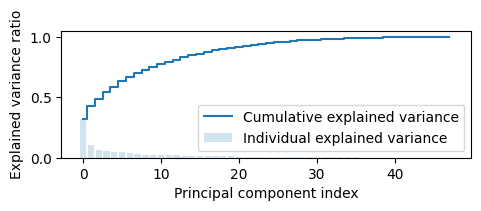

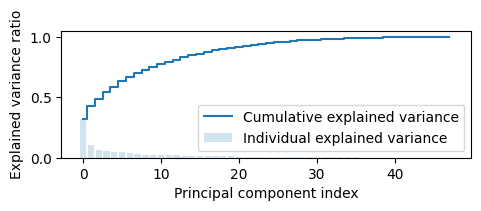

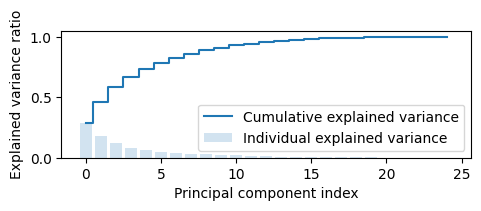

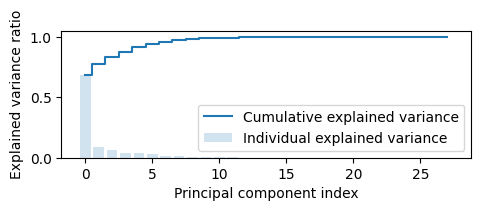

In [13]:
index = pd.concat([br_pd, sill_pd, viscode_pd, score_pd], axis=1, join='inner').index
sill_pca_np, sill_comp = plt_pca(sill_pd.loc[index], 'SILL PCA', 0.9)
br_pca_np, br_comp = plt_pca(br_pd.loc[index], 'BookRoll PCA', 0.9)
viscode_pca_np, viscode_comp = plt_pca(viscode_pd.loc[index], 'VisCode PCA', 0.9)

# 1. Predict Risk Student

In [18]:
srl_m_pd = srl_m_pd[~srl_m_pd.index.duplicated()]

merged_pd = pd.concat([br_pd, sill_pd, viscode_pd, score_pd], axis=1)
merged_pd = pd.concat([br_pd, viscode_pd, srl_m_pd, sill_pd, score_pd], axis=1)
merged_pd = merged_pd.drop(columns=['REGIST CONTENTS'])

merged_pd = merged_pd[merged_pd['score'].notna()]
merged_pd = merged_pd.fillna(0)

In [19]:
merged_pd['label']=0
merged_pd.loc[merged_pd['score'] > 88, 'label']=1
merged_pd.shape

(198, 134)

In [30]:
def normalization (normal_df):
    
    min_max_scaler = preprocessing.MinMaxScaler()
    feature_names = list(normal_df)
    
    min_max_scaler = min_max_scaler.fit(normal_df)
    X_raw_minmax = min_max_scaler.transform(normal_df)
    normal_df = pd.DataFrame(X_raw_minmax, columns=feature_names)

    return normal_df, min_max_scaler

In [31]:
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

## 1-1. Training Model A by using Class A, and evaluate performance by Class B

In [32]:
xa = merged_pd[merged_pd['class']=='a'].drop(columns=['score', 'label', 'class'])
xb = merged_pd[merged_pd['class']=='b'].drop(columns=['score', 'label', 'class'])

ya = merged_pd[merged_pd['class']=='a']['label']
yb = merged_pd[merged_pd['class']=='b']['label']

In [33]:
_, normalizer = normalization(xa)
xa_norm = normalizer.transform(xa)
xb_norm = normalizer.transform(xb)

In [35]:
pca = PCA(n_components=21)
pca.fit(xa_norm)

xa_pca = pca.transform(xa_norm)
xb_pca = pca.transform(xb_norm)

In [36]:
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import GridSearchCV

In [37]:
param_grid = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
              'C': [0.001, 0.1, 1, 10, 100]}

svc_classa = SVC()

sh = HalvingGridSearchCV(svc_classa, param_grid, cv=10,
                         factor=2, max_resources=70,
                         aggressive_elimination=False).fit(xa_pca, ya)


In [38]:
sh.best_estimator_

SVC(C=0.1, kernel='linear')

In [39]:
scores = cross_val_score(estimator=sh.best_estimator_, 
                         X=xa_pca, 
                         y=ya, cv=10)
scores.mean()

0.6976190476190476

In [40]:
scores = cross_val_score(estimator=sh.best_estimator_, 
                         X=xb_pca, 
                         y=yb, cv=10)
scores.mean()

0.7333333333333333

## 1-2. Training Model B by using Class B, and evaluate performance by Class A

In [41]:
eval_range = range(70, 90)
opt_comp = 0.8

In [42]:
def Average(lst):
    return sum(lst) / len(lst)

In [43]:
score_a_list = []
score_b_list = []
th_list = []

balance_a_list = []
balance_b_list = []

for s in eval_range:
# for s in range(60, 92):
    
    merged_pd['label']=1
    merged_pd.loc[merged_pd['score'] > s, 'label']=0
    merged_pd.shape
    
    xa = merged_pd[merged_pd['class']=='a'].drop(columns=['score', 'label', 'class'])
    xb = merged_pd[merged_pd['class']=='b'].drop(columns=['score', 'label', 'class'])

    ya = merged_pd[merged_pd['class']=='a']['label']
    yb = merged_pd[merged_pd['class']=='b']['label']
    
    balance_a_list.append(len(ya[ya == 1]) / len(ya[ya == 0]))
    balance_b_list.append(len(yb[yb == 1]) / len(yb[yb == 0]))
    
    comp = get_pca(xa, opt_comp)
    
    normalizer_a = StandardScaler()
    normalizer_a.fit(xa)
    xa_norm = normalizer_a.transform(xa)
    xb_norm = normalizer_a.transform(xb)
    
    pca_a = PCA(n_components=comp)
    pca_a.fit(xa_norm)
    xa_pca = pca_a.transform(xa_norm)
    xb_pca = pca_a.transform(xb_norm)
    
    param_grid = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
                  'degree': [0, 1, 3, 5, 7] ,
                  'C': [0.001, 0.1, 1, 10, 100]}

    svc_classa = SVC()

#     sh = HalvingGridSearchCV(svc_classb, param_grid, cv=10,
#                              factor=2, max_resources=70,
#                              aggressive_elimination=False).fit(xa_pca, ya)
    
    sh = GridSearchCV(svc_classa, param_grid, cv=10).fit(xa_pca, ya)
    
    scores_a = cross_val_score(estimator=sh.best_estimator_, 
                         X=xa_pca, 
                         y=ya, cv=10).mean()

    scores_b = cross_val_score(estimator=sh.best_estimator_, 
                         X=xb_pca, 
                         y=yb, cv=10).mean()
    
    score_a_list.append(scores_a)
    score_b_list.append(scores_b)
    th_list.append(s)

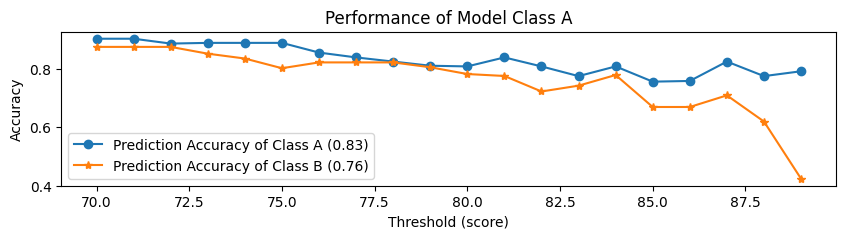

In [44]:
plt.figure(figsize=(10, 2))

plt.plot(th_list, score_a_list, marker = 'o', label='Prediction Accuracy of Class A ('+str(round(Average(score_a_list), 2))+')')
plt.plot(th_list, score_b_list, marker = '*', label='Prediction Accuracy of Class B ('+str(round(Average(score_b_list), 2))+')')

plt.title('Performance of Model Class A')
plt.ylabel('Accuracy')
plt.xlabel('Threshold (score)')
plt.legend()
plt.show()

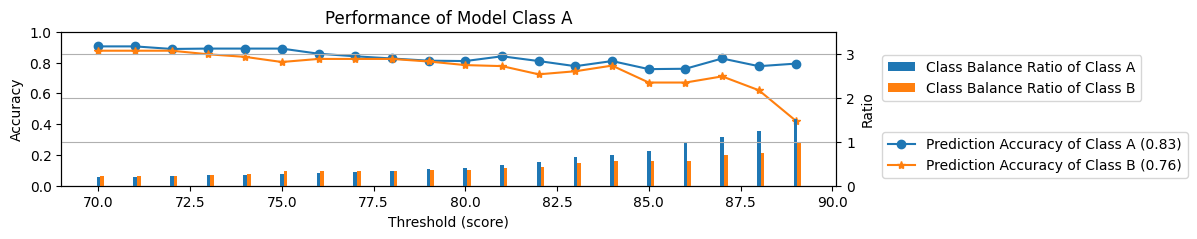

In [45]:
fig = plt.figure(figsize=(10, 2))

ax = fig.add_subplot(111)
ax.plot(th_list, score_a_list, marker = 'o', label='Prediction Accuracy of Class A ('+str(round(Average(score_a_list), 2))+')')
ax.plot(th_list, score_b_list, marker = '*', label='Prediction Accuracy of Class B ('+str(round(Average(score_b_list), 2))+')')

width = 0.1
ax2 = ax.twinx()
ax2.bar(th_list, balance_a_list, width=width, label='Class Balance Ratio of Class A')
ax2.bar([x+width for x in th_list], balance_b_list, width=width, label='Class Balance Ratio of Class B')

ax2.set_ylim(0, 3.5)
ax.set_ylim(0,1)

plt.title('Performance of Model Class A')

ax.set_ylabel('Accuracy')
ax.set_xlabel('Threshold (score)')
ax2.set_ylabel('Ratio')
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.2))
ax2.legend(loc='center left', bbox_to_anchor=(1.05, 0.7))


plt.grid()
plt.show()

## 1-3 Training

In [46]:
merged_pd = pd.concat([br_pd, viscode_pd, srl_m_pd, score_pd], axis=1)
merged_pd = merged_pd.drop(columns=['REGIST CONTENTS'])

merged_pd = merged_pd[merged_pd['score'].notna()]
# merged_pd = merged_pd.dropna()
merged_pd = merged_pd.fillna(0)

In [47]:
score_a_list = []
score_b_list = []
score_c_list = []
th_list = []

balance_a_list = []
balance_b_list = []
balance_c_list = []

for s in eval_range:
    
    merged_pd['label']=1
    merged_pd.loc[merged_pd['score'] > s, 'label']=0
    merged_pd.shape
    
    xa = merged_pd[merged_pd['class']=='a'].drop(columns=['score', 'label', 'class'])
    xb = merged_pd[merged_pd['class']=='b'].drop(columns=['score', 'label', 'class'])
    xc = merged_pd[merged_pd['class']=='c'].drop(columns=['score', 'label', 'class'])

    ya = merged_pd[merged_pd['class']=='a']['label']
    yb = merged_pd[merged_pd['class']=='b']['label']
    yc = merged_pd[merged_pd['class']=='c']['label']
    
    balance_a_list.append(len(ya[ya == 1]) / len(ya[ya == 0]))
    balance_b_list.append(len(yb[yb == 1]) / len(yb[yb == 0]))
    balance_c_list.append(len(yc[yc == 1]) / len(yc[yc == 0]))
    
    comp = get_pca(xa, opt_comp)
    
    normalizer_a = StandardScaler()
    normalizer_a.fit(xa)
    xa_norm = normalizer_a.transform(xa)
    xb_norm = normalizer_a.transform(xb)
    xc_norm = normalizer_a.transform(xc)
    
    pca_a = PCA(n_components=comp)
    pca_a.fit(xa_norm)
    xa_pca = pca_a.transform(xa_norm)
    xb_pca = pca_a.transform(xb_norm)
    xc_pca = pca_a.transform(xc_norm)
    
    param_grid = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
                  'degree': [0, 1, 3, 5, 7] ,
                  'C': [0.001, 0.1, 1, 10, 100]}

    svc_classa = SVC()

#     sh = HalvingGridSearchCV(svc_classb, param_grid, cv=10,
#                              factor=2, max_resources=70,
#                              aggressive_elimination=False).fit(xa_pca, ya)
    
    sh = GridSearchCV(svc_classa, param_grid, cv=10).fit(xa_pca, ya)
    
    scores_a = cross_val_score(estimator=sh.best_estimator_, 
                         X=xa_pca, 
                         y=ya, cv=10).mean()

    scores_b = cross_val_score(estimator=sh.best_estimator_, 
                         X=xb_pca, 
                         y=yb, cv=10).mean()
    scores_c = cross_val_score(estimator=sh.best_estimator_, 
                         X=xc_pca, 
                         y=yc, cv=10).mean()
    
    score_a_list.append(scores_a)
    score_b_list.append(scores_b)
    score_c_list.append(scores_c)
    th_list.append(s)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklear

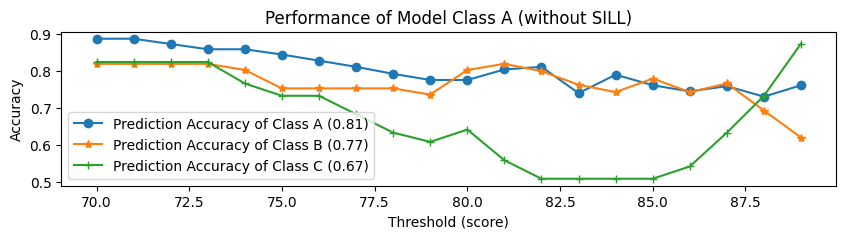

In [48]:
plt.figure(figsize=(10, 2))

plt.plot(th_list, score_a_list, marker = 'o', label='Prediction Accuracy of Class A ('+str(round(Average(score_a_list), 2))+')')
plt.plot(th_list, score_b_list, marker = '*', label='Prediction Accuracy of Class B ('+str(round(Average(score_b_list), 2))+')')
plt.plot(th_list, score_c_list, marker = '+', label='Prediction Accuracy of Class C ('+str(round(Average(score_c_list), 2))+')')


plt.title('Performance of Model Class A (without SILL)')
plt.ylabel('Accuracy')
plt.xlabel('Threshold (score)')
plt.legend()
plt.show()

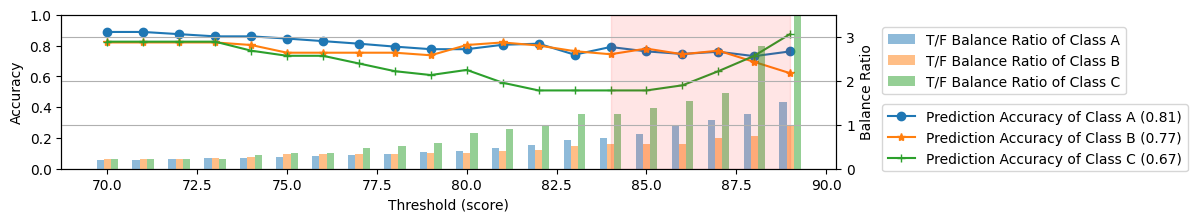

In [49]:
fig = plt.figure(figsize=(10, 2))

ax = fig.add_subplot(111)
ax.plot(th_list, score_a_list, marker = 'o', label='Prediction Accuracy of Class A ('+str(round(Average(score_a_list), 2))+')')
ax.plot(th_list, score_b_list, marker = '*', label='Prediction Accuracy of Class B ('+str(round(Average(score_b_list), 2))+')')
ax.plot(th_list, score_c_list, marker = '+', label='Prediction Accuracy of Class C ('+str(round(Average(score_c_list), 2))+')')

width = 0.2
ax2 = ax.twinx()
ax2.bar([x-width for x in th_list], balance_a_list, alpha=0.5, align='center', width=width, label='T/F Balance Ratio of Class A')
ax2.bar([x for x in th_list], balance_b_list, alpha=0.5, align='center', width=width, label='T/F Balance Ratio of Class B')
ax2.bar([x+width for x in th_list], balance_c_list, alpha=0.5, align='center', width=width, label='T/F Balance Ratio of Class C')

ax2.set_ylim(0, 3.5)
ax.set_ylim(0,1)

plt.axvspan(84, 89, color='red', alpha=0.1)

# plt.title('Performance of Model Class A (without SILL)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Threshold (score)')
ax2.set_ylabel('Balance Ratio')
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.2))
ax2.legend(loc='center left', bbox_to_anchor=(1.05, 0.7))

plt.grid()
plt.show()

In [50]:
score_a_list = []
score_b_list = []
score_c_list = []
th_list = []

for s in eval_range:
    
    merged_pd['label']=1
    merged_pd.loc[merged_pd['score'] > s, 'label']=0
    merged_pd.shape
    
    xa = merged_pd[merged_pd['class']=='a'].drop(columns=['score', 'label', 'class'])
    xb = merged_pd[merged_pd['class']=='b'].drop(columns=['score', 'label', 'class'])
    xc = merged_pd[merged_pd['class']=='c'].drop(columns=['score', 'label', 'class'])

    ya = merged_pd[merged_pd['class']=='a']['label']
    yb = merged_pd[merged_pd['class']=='b']['label']
    yc = merged_pd[merged_pd['class']=='c']['label']
    
    
    
    comp = get_pca(xb, opt_comp)
    
    normalizer_b = StandardScaler()
    normalizer_b.fit(xb)
    xa_norm = normalizer_b.transform(xa)
    xb_norm = normalizer_b.transform(xb)
    xc_norm = normalizer_b.transform(xc)
    
    pca_b = PCA(n_components=comp)
    pca_b.fit(xb_norm)
    xa_pca = pca_b.transform(xa_norm)
    xb_pca = pca_b.transform(xb_norm)
    xc_pca = pca_b.transform(xc_norm)
    
    param_grid = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
                  'degree': [0, 1, 3, 5, 7] ,
                  'C': [0.001, 0.1, 1, 10, 100]}

    svc_classb = SVC()
    
    sh = GridSearchCV(svc_classb, param_grid, cv=10).fit(xb_pca, yb)
    
    scores_a = cross_val_score(estimator=sh.best_estimator_, 
                         X=xa_pca, 
                         y=ya, cv=10).mean()

    scores_b = cross_val_score(estimator=sh.best_estimator_, 
                         X=xb_pca, 
                         y=yb, cv=10).mean()
    
    scores_c = cross_val_score(estimator=sh.best_estimator_, 
                         X=xc_pca, 
                         y=yc, cv=10).mean()
    
    score_a_list.append(scores_a)
    score_b_list.append(scores_b)
    score_c_list.append(scores_c)
    th_list.append(s)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklear

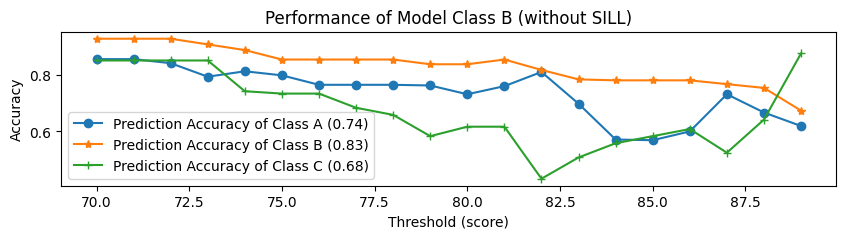

In [51]:
plt.figure(figsize=(10, 2))

plt.plot(th_list, score_a_list, marker = 'o', label='Prediction Accuracy of Class A ('+str(round(Average(score_a_list), 2))+')')
plt.plot(th_list, score_b_list, marker = '*', label='Prediction Accuracy of Class B ('+str(round(Average(score_b_list), 2))+')')
plt.plot(th_list, score_c_list, marker = '+', label='Prediction Accuracy of Class C ('+str(round(Average(score_c_list), 2))+')')


plt.title('Performance of Model Class B (without SILL)')
plt.ylabel('Accuracy')
plt.xlabel('Threshold (score)')
plt.legend()
plt.show()

In [ ]:
score_a_list = []
score_b_list = []
score_c_list = []
th_list = []

balance_a_list = []
balance_b_list = []
balance_c_list = []

for s in eval_range:
# for s in range(65, 90):
    
    merged_pd['label']=1
    merged_pd.loc[merged_pd['score'] > s, 'label']=0
    merged_pd.shape
    
    xa = merged_pd[merged_pd['class']=='a'].drop(columns=['score', 'label', 'class'])
    xb = merged_pd[merged_pd['class']=='b'].drop(columns=['score', 'label', 'class'])
    xc = merged_pd[merged_pd['class']=='c'].drop(columns=['score', 'label', 'class'])

    ya = merged_pd[merged_pd['class']=='a']['label']
    yb = merged_pd[merged_pd['class']=='b']['label']
    yc = merged_pd[merged_pd['class']=='c']['label']
    
    balance_a_list.append(len(ya[ya == 1]) / len(ya[ya == 0]))
    balance_b_list.append(len(yb[yb == 1]) / len(yb[yb == 0]))
    balance_c_list.append(len(yc[yc == 1]) / len(yc[yc == 0]))
    
    comp = get_pca(xc, 0.8)
    
    normalizer_c = StandardScaler()
    normalizer_c.fit(xc)
    xa_norm = normalizer_c.transform(xa)
    xb_norm = normalizer_c.transform(xb)
    xc_norm = normalizer_c.transform(xc)

    
    pca_c = PCA(n_components=opt_comp)
    pca_c.fit(xc_norm)
    xa_pca = pca_b.transform(xa_norm)
    xb_pca = pca_b.transform(xb_norm)
    xc_pca = pca_b.transform(xc_norm)
    
    param_grid = {'kernel': ('linear', 'poly', 'rbf', 'sigmoid'),
                  'degree': [0, 1, 3, 5, 7] ,
                  'C': [0.001, 0.1, 1, 10, 100]}

    svc_classc = SVC()

#     sh = HalvingGridSearchCV(svc_classb, param_grid, cv=10,
#                              factor=2, max_resources=70,
#                              aggressive_elimination=False).fit(xa_pca, ya)
    
    sh = GridSearchCV(svc_classc, param_grid, cv=10).fit(xc_pca, yc)
    
    scores_a = cross_val_score(estimator=sh.best_estimator_, 
                         X=xa_pca, 
                         y=ya, cv=10).mean()

    scores_b = cross_val_score(estimator=sh.best_estimator_, 
                         X=xb_pca, 
                         y=yb, cv=10).mean()
    
    scores_c = cross_val_score(estimator=sh.best_estimator_, 
                         X=xc_pca, 
                         y=yc, cv=10).mean()
    
    score_a_list.append(scores_a)
    score_b_list.append(scores_b)
    score_c_list.append(scores_c)
    th_list.append(s)

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 7 members, which is less than n_splits=10.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklear

In [ ]:
plt.figure(figsize=(10, 2))

plt.plot(th_list, score_a_list, marker = 'o', label='Prediction Accuracy of Class A ('+str(round(Average(score_a_list), 2))+')')
plt.plot(th_list, score_b_list, marker = '*', label='Prediction Accuracy of Class B ('+str(round(Average(score_b_list), 2))+')')
plt.plot(th_list, score_c_list, marker = '+', label='Prediction Accuracy of Class C ('+str(round(Average(score_c_list), 2))+')')


plt.title('Performance of Model Class C (without SILL)')
plt.ylabel('Accuracy')
plt.xlabel('Threshold (score)')
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10, 2))

ax = fig.add_subplot(111)
ax.plot(th_list, score_a_list, marker = 'o', label='Prediction Accuracy of Class A ('+str(round(Average(score_a_list), 2))+')')
ax.plot(th_list, score_b_list, marker = '*', label='Prediction Accuracy of Class B ('+str(round(Average(score_b_list), 2))+')')
plt.plot(th_list, score_c_list, marker = '+', label='Prediction Accuracy of Class C ('+str(round(Average(score_c_list), 2))+')')

width = 0.1
ax2 = ax.twinx()
ax2.bar(th_list, balance_a_list, width=width, label='Balance Ratio of Class A')
ax2.bar([x+width for x in th_list], balance_b_list, width=width, label='Balance Ratio of Class B')
ax2.bar([x+2*width for x in th_list], balance_c_list, width=width, label='Balance Ratio of Class C')

# ax.legend(loc=0)
# ax.grid()
# ax.set_xlabel("Time (h)")
# ax.set_ylabel(r"Radiation ($MJ\,m^{-2}\,d^{-1}$)")
# ax2.set_ylabel(r"Temperature ($^\circ$C)")
ax2.set_ylim(0, 3.5)
ax.set_ylim(0,1)

plt.title('Performance of Model Class C (without SILL)')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Threshold (score)')
ax2.set_ylabel('Ratio')
ax.legend(loc='center left', bbox_to_anchor=(1.05, 0.2))
ax2.legend(loc='center left', bbox_to_anchor=(1.05, 0.7))

plt.grid()
plt.show()